<a href="https://colab.research.google.com/github/basileplus/EncodeDecoder/blob/main/455TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow==2.14
!pip install tensorflow-probability==0.22
!pip install tensorflow-compression~=2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling te

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [ ]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_1"),
    tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_2"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
    tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
    tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
    tf.keras.layers.Dense(2450, use_bias=True, activation="leaky_relu", name="fc_2"),
    tf.keras.layers.Reshape((7, 7, 50)),
    tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_1"),
    tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [ ]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""
  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))
  @property

  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))
    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
    self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)
    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)
    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))
    return dict(rate=rate, distortion=distortion)

In [ ]:
training_dataset, validation_dataset = tfds.load(
"mnist",
split=["train", "test"],
shuffle_files=True,
as_supervised=True,
with_info=False,
)

training_dataset = training_dataset.take(10000)
validation_dataset = validation_dataset.take(1000)

In [ ]:
print(len(training_dataset))

10000


In [ ]:
# Accéder aux informations sur l'ensemble de données
mnist_info = tfds.builder("mnist")
print(mnist_info.info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


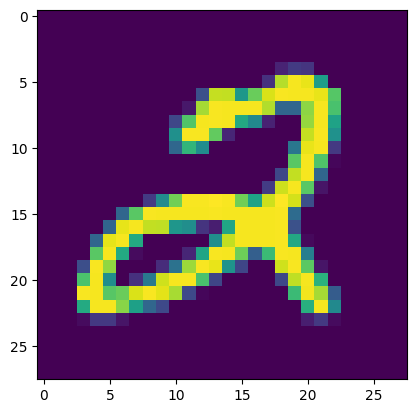

In [ ]:
(x, _), = validation_dataset.take(1)
plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

In [ ]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)
print(f"Data type: {y.dtype}")
print(f"Shape: {y.shape}")

Data type: <dtype: 'float32'>
Shape: (1, 10)


In [ ]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

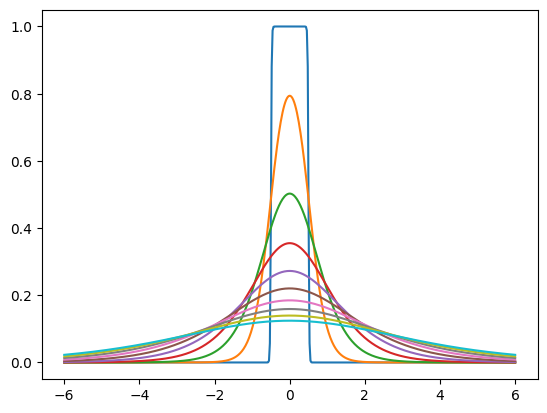

In [ ]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))
_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));

In [ ]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)
rate

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([18.265387], dtype=float32)>

distortion: tf.Tensor(0.17140625, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


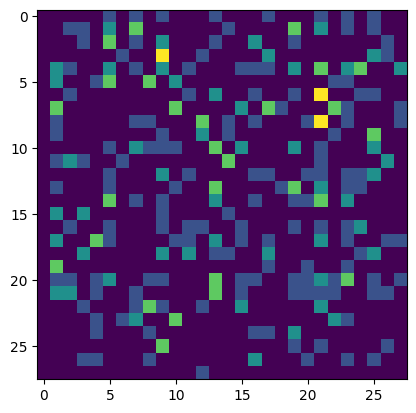

In [ ]:
x_tilde = make_synthesis_transform()(y_tilde)
# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)
x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


In [ ]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)
print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


## Training of the model

In [ ]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=10):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  # Just pass through rate and distortion as losses/metrics.
  loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
  metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
  loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [ ]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=5,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
  verbose=1,
  )
  return trainer


In [ ]:
trainer = train_mnist_model(lmbda=2000)

Epoch 1/10
30/79 [==========>...................] - ETA: 8s - loss: 272.7984 - distortion_loss: 0.1258 - rate_loss: 21.1638 - distortion_pass_through_loss: 0.1258 - rate_pass_through_loss: 21.1638

KeyboardInterrupt: 

In [ ]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""
  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""
  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


In [ ]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
  trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

In [ ]:
compressor, decompressor = make_mnist_codec(trainer)

In [ ]:
strings, entropies = compressor(originals)
print(f"String representation of digit in hex: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

NameError: name 'originals' is not defined

In [ ]:
reconstructions = decompressor(strings)

In [ ]:
def tf_psnr(original, reconstructed):
    # Ensure the pixel values are floats (especially important if the images are uint8)
    original = tf.cast(original, tf.float32)
    reconstructed = tf.cast(reconstructed, tf.float32)

    # Calculate MSE using TensorFlow's mean and square functions
    mse = tf.reduce_mean(tf.square(original - reconstructed))

    # Define the maximum pixel value. Change this if you're not using 8-bit images.
    max_pixel = 255.0

    # Calculate PSNR
    psnr = 20 * tf.math.log(max_pixel / tf.sqrt(mse)) / tf.math.log(10.0)

    return psnr

# Example usage:
# Assume `originals` and `reconstructions` are tensors of the same shape
# originals, reconstructions = ... (load your tensor data here)

# Calculate PSNR for one pair of images or batches
#psnr_value = tf_psnr(originals, reconstructions)

In [ ]:
def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  psnr=[]
  for i in range(len(axes)):
    image = tf.concat([
      tf.squeeze(originals[i]),
      tf.zeros((28, 14), tf.uint8),
      tf.squeeze(reconstructions[i]),
    ], 1)
    psnr_im = tf_psnr(originals[i],reconstructions[i]).numpy()
    psnr.append(psnr_im)
    axes[i].imshow(image)
    axes[i].text(
    .5, .5, f"? 0x{strings[i].numpy().hex()} ?\n{entropies[i]:0.2f} bits\n PSNR : {psnr[i]:0.2f}",
    ha="center", va="top", color="white", fontsize="small",
    transform=axes[i].transAxes)
    axes[i].axis("off")

  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

In [ ]:
display_digits(originals, strings, entropies, reconstructions)

redefine train_and_visualize_model function to return avg_psnr and entropy

In [ ]:
def train_and_visualize_model(lmbda):
    trainer = train_mnist_model(lmbda=lmbda)
    compressor, decompressor = make_mnist_codec(trainer)
    originals, _ = validation_dataset.batch(16).take(1).as_numpy_iterator().next()
    strings, entropies = compressor(originals)
    reconstructions = decompressor(strings)

    psnr_values = [tf_psnr(originals[i], reconstructions[i]).numpy() for i in range(len(originals))]
    average_psnr = sum(psnr_values) / len(psnr_values)
    average_entropy = sum(entropies.numpy()) / len(entropies)

    return average_psnr, average_entropy



train and evaluate for different lambdas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lambdas = np.linspace(100, 2000, 5)  # Example range for lambda
psnr_data = []
entropy_data = []

for lmbda in lambdas:
    psnr, entropy = train_and_visualize_model(lmbda)
    psnr_data.append(psnr)
    entropy_data.append(entropy)

# Now psnr_data and entropy_data contain the average PSNR and entropy for each lambda


Epoch 1/5
78/79 [============================>.] - ETA: 0s - loss: 32.3482 - distortion_loss: 0.1213 - rate_loss: 20.2164 - distortion_pass_through_loss: 0.1213 - rate_pass_through_loss: 20.2164

79/79 [==============================] - 16s 168ms/step - loss: 32.3461 - distortion_loss: 0.1213 - rate_loss: 20.2162 - distortion_pass_through_loss: 0.1212 - rate_pass_through_loss: 20.2148 - val_loss: 30.4054 - val_distortion_loss: 0.1039 - val_rate_loss: 20.0133 - val_distortion_pass_through_loss: 0.1038 - val_rate_pass_through_loss: 20.0120
Epoch 2/5
79/79 [==============================] - 18s 221ms/step - loss: 29.1490 - distortion_loss: 0.0932 - rate_loss: 19.8281 - distortion_pass_through_loss: 0.0931 - rate_pass_through_loss: 19.8293 - val_loss: 28.5494 - val_distortion_loss: 0.0915 - val_rate_loss: 19.3986 - val_distortion_pass_through_loss: 0.0914 - val_rate_pass_through_loss: 19.3972
Epoch 3/5
79/79 [==============================] - 16s 197ms/step - loss: 27.6912 - distortion_loss: 0.0857 - rate_loss: 19.1218 - distortion_pass_through_loss: 0.0856 - rate_pass_through_loss: 19.1195 - val_loss: 27.1358 - val_distortion_loss: 0.0836 - val_rate_loss: 18.7802 - val_distortion_

79/79 [==============================] - 15s 150ms/step - loss: 85.7192 - distortion_loss: 0.1126 - rate_loss: 20.9808 - distortion_pass_through_loss: 0.1123 - rate_pass_through_loss: 20.9939 - val_loss: 71.0437 - val_distortion_loss: 0.0854 - val_rate_loss: 21.9353 - val_distortion_pass_through_loss: 0.0854 - val_rate_pass_through_loss: 21.9315
Epoch 2/5
79/79 [==============================] - 11s 140ms/step - loss: 66.4321 - distortion_loss: 0.0768 - rate_loss: 22.2501 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 22.2550 - val_loss: 64.0338 - val_distortion_loss: 0.0729 - val_rate_loss: 22.1103 - val_distortion_pass_through_loss: 0.0729 - val_rate_pass_through_loss: 22.1057
Epoch 3/5
79/79 [==============================] - 12s 152ms/step - loss: 62.4030 - distortion_loss: 0.0701 - rate_loss: 22.1012 - distortion_pass_through_loss: 0.0700 - rate_pass_through_loss: 22.1001 - val_loss: 61.4513 - val_distortion_loss: 0.0686 - val_rate_loss: 22.0344 - val_distortion_

79/79 [==============================] - 15s 154ms/step - loss: 136.3522 - distortion_loss: 0.1093 - rate_loss: 21.5846 - distortion_pass_through_loss: 0.1090 - rate_pass_through_loss: 21.6042 - val_loss: 111.1137 - val_distortion_loss: 0.0840 - val_rate_loss: 22.9001 - val_distortion_pass_through_loss: 0.0840 - val_rate_pass_through_loss: 22.8963
Epoch 2/5
79/79 [==============================] - 13s 157ms/step - loss: 102.6724 - distortion_loss: 0.0754 - rate_loss: 23.5074 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 23.5152 - val_loss: 97.4598 - val_distortion_loss: 0.0704 - val_rate_loss: 23.4985 - val_distortion_pass_through_loss: 0.0704 - val_rate_pass_through_loss: 23.4953
Epoch 3/5
79/79 [==============================] - 13s 167ms/step - loss: 94.3845 - distortion_loss: 0.0671 - rate_loss: 23.9390 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 23.9427 - val_loss: 92.0788 - val_distortion_loss: 0.0650 - val_rate_loss: 23.8706 - val_distorti

79/79 [==============================] - 16s 155ms/step - loss: 182.8491 - distortion_loss: 0.1053 - rate_loss: 22.3278 - distortion_pass_through_loss: 0.1050 - rate_pass_through_loss: 22.3522 - val_loss: 145.5802 - val_distortion_loss: 0.0795 - val_rate_loss: 24.3270 - val_distortion_pass_through_loss: 0.0794 - val_rate_pass_through_loss: 24.3200
Epoch 2/5
79/79 [==============================] - 12s 152ms/step - loss: 133.8304 - distortion_loss: 0.0713 - rate_loss: 25.1204 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 25.1315 - val_loss: 127.3032 - val_distortion_loss: 0.0667 - val_rate_loss: 25.5141 - val_distortion_pass_through_loss: 0.0667 - val_rate_pass_through_loss: 25.5062
Epoch 3/5
79/79 [==============================] - 12s 149ms/step - loss: 123.9091 - distortion_loss: 0.0644 - rate_loss: 25.7150 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 25.7194 - val_loss: 121.9505 - val_distortion_loss: 0.0629 - val_rate_loss: 26.0480 - val_disto

79/79 [==============================] - 16s 163ms/step - loss: 228.2066 - distortion_loss: 0.1027 - rate_loss: 22.8538 - distortion_pass_through_loss: 0.1024 - rate_pass_through_loss: 22.8861 - val_loss: 179.8403 - val_distortion_loss: 0.0774 - val_rate_loss: 25.1047 - val_distortion_pass_through_loss: 0.0773 - val_rate_pass_through_loss: 25.0973
Epoch 2/5
79/79 [==============================] - 12s 152ms/step - loss: 166.1337 - distortion_loss: 0.0700 - rate_loss: 26.2195 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 26.2303 - val_loss: 157.8629 - val_distortion_loss: 0.0656 - val_rate_loss: 26.6385 - val_distortion_pass_through_loss: 0.0656 - val_rate_pass_through_loss: 26.6342
Epoch 3/5
79/79 [==============================] - 13s 161ms/step - loss: 154.2591 - distortion_loss: 0.0637 - rate_loss: 26.9014 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 26.9096 - val_loss: 150.7312 - val_distortion_loss: 0.0619 - val_rate_loss: 26.8489 - val_disto

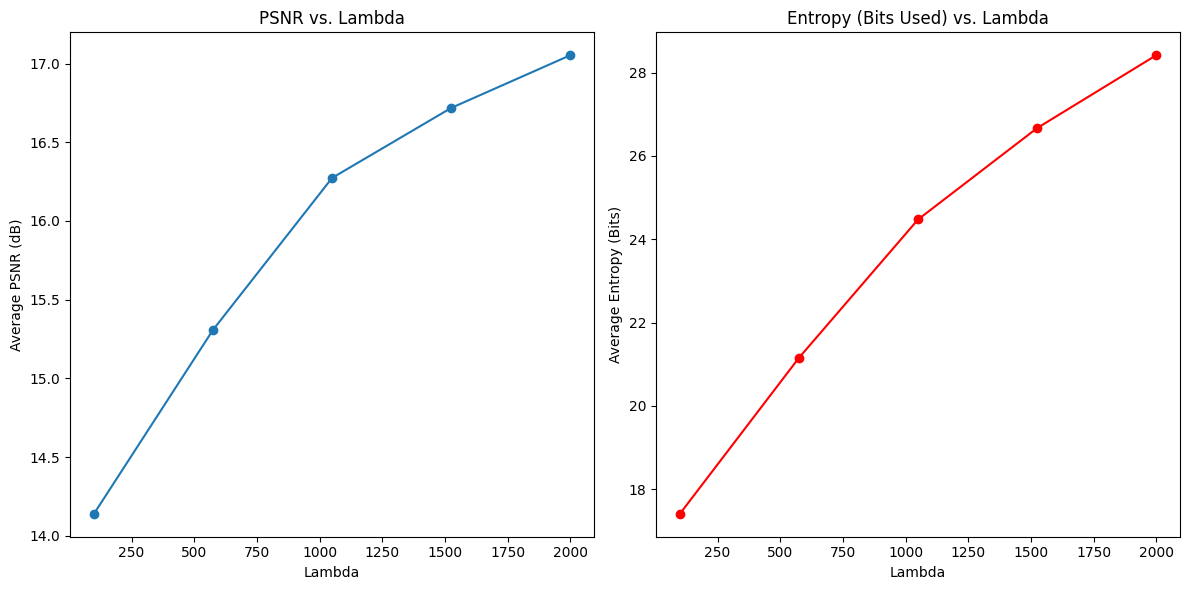

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lambdas, psnr_data, marker='o')
plt.title('PSNR vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average PSNR (dB)')

plt.subplot(1, 2, 2)
plt.plot(lambdas, entropy_data, marker='o', color='red')
plt.title('Entropy (Bits Used) vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Average Entropy (Bits)')

plt.tight_layout()
plt.show()


# Generation d'image

In [ ]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)

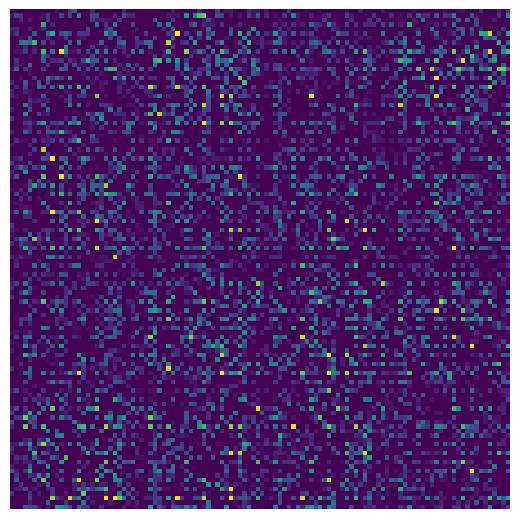

In [ ]:
import os
strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)